In [1]:
import sys
import os

PROJECT_ROOT = "/home/maitanha/cll_vlm/cll_vlm"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PYTHONPATH updated")

import torch
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm
from PIL import Image

from models.clip_model import CLIPModel
from dataset.cifar10 import CIFAR10Dataset
from dataset.cifar20 import CIFAR20Dataset, CIFAR100Dataset

PYTHONPATH updated


/home/maitanha/cll_vlm/venv_cll_llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/maitanha/cll_vlm/cll_vlm/vlm/CLIP


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 256         
num_workers = 4              # số luồng đọc dữ liệu

dataset = CIFAR20Dataset(
    root="/home/maitanha/cll_vlm/cll_vlm/data/cifar20",
    train=True
)
label_names = dataset.classes  # ['airplane', 'automobile', 'bird', ...]
print("Labels:", label_names)
print(f"Total samples: {len(dataset)}")

def collate_fn(batch):
    imgs, targets = zip(*batch)
    return list(imgs), torch.tensor(targets)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

Labels: ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']
Total samples: 50000


In [3]:
clip_model = CLIPModel(model_name="ViT-L/14@336px", device=device)

def preprocess_label(label: str) -> str:
    # special case for vehicles
    if label.startswith("vehicles"):
        return "vehicles"
    
    # general case
    return label.replace("_", " ")

processed_labels = [preprocess_label(lbl) for lbl in label_names]

texts = [f"A photo of a {label}" for label in processed_labels]
text_features = clip_model.encode_text(texts)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [4]:
import os
import numpy as np
import torch
from tqdm import tqdm

# ===== Output path =====
save_dir = "/home/maitanha/cll_vlm/cll_vlm/cifar_clip_similarity"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "cifar20_img_class_similarity.npy")

num_images = len(dataset)
num_classes = len(label_names)  # 20 superclasses

# ===== Pre-allocate similarity matrix =====
sim_matrix = np.zeros(
    (num_images, num_classes),
    dtype=np.float32
)

ptr = 0

clip_model.model.eval()
with torch.no_grad():
    for images, _ in tqdm(dataloader, desc="Computing CLIP similarity"):
        bsz = len(images)

        # Encode images
        image_features = clip_model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Compute similarity (cosine since normalized)
        sims = image_features @ text_features.T   # (B, 20)

        # Save to matrix
        sim_matrix[ptr:ptr + bsz] = sims.cpu().numpy().astype(np.float32)
        ptr += bsz

# ===== Save to .npy =====
np.save(save_path, sim_matrix)

print(f"[DONE] Saved CLIP similarity to: {save_path}")
print(f"Shape: {sim_matrix.shape}, dtype: {sim_matrix.dtype}")


Computing CLIP similarity: 100%|██████████| 196/196 [06:11<00:00,  1.90s/it]


[DONE] Saved CLIP similarity to: /home/maitanha/cll_vlm/cll_vlm/cifar_clip_similarity/cifar20_img_class_similarity.npy
Shape: (50000, 20), dtype: float32


# CIFAR 100

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 256         
num_workers = 4              # số luồng đọc dữ liệu

dataset = CIFAR100Dataset(
    root="/home/maitanha/cll_vlm/cll_vlm/data/cifar100",
    train=True
)
label_names = dataset.classes  # ['airplane', 'automobile', 'bird', ...]
print("Labels:", label_names)
print(f"Total samples: {len(dataset)}")

def collate_fn(batch):
    imgs, targets = zip(*batch)
    return list(imgs), torch.tensor(targets)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

Labels: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willo

In [6]:
clip_model = CLIPModel(model_name="ViT-L/14@336px", device=device)

def preprocess_label(label: str) -> str:
    # special case for vehicles
    if label.startswith("vehicles"):
        return "vehicles"
    
    # general case
    return label.replace("_", " ")

processed_labels = [preprocess_label(lbl) for lbl in label_names]

texts = [f"A photo of a {label}" for label in processed_labels]
text_features = clip_model.encode_text(texts)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [7]:
import os
import numpy as np
import torch
from tqdm import tqdm

# ===== Output path =====
save_dir = "/home/maitanha/cll_vlm/cll_vlm/cifar_clip_similarity"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "cifar100_img_class_similarity.npy")

num_images = len(dataset)
num_classes = len(label_names)  # 100 classes

# ===== Pre-allocate similarity matrix =====
sim_matrix = np.zeros(
    (num_images, num_classes),
    dtype=np.float32
)

ptr = 0

clip_model.model.eval()
with torch.no_grad():
    for images, _ in tqdm(dataloader, desc="Computing CLIP similarity"):
        bsz = len(images)

        # Encode images
        image_features = clip_model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Compute similarity (cosine since normalized)
        sims = image_features @ text_features.T   # (B, 20)

        # Save to matrix
        sim_matrix[ptr:ptr + bsz] = sims.cpu().numpy().astype(np.float32)
        ptr += bsz

# ===== Save to .npy =====
np.save(save_path, sim_matrix)

print(f"[DONE] Saved CLIP similarity to: {save_path}")
print(f"Shape: {sim_matrix.shape}, dtype: {sim_matrix.dtype}")


Computing CLIP similarity: 100%|██████████| 196/196 [05:58<00:00,  1.83s/it]


[DONE] Saved CLIP similarity to: /home/maitanha/cll_vlm/cll_vlm/cifar_clip_similarity/cifar100_img_class_similarity.npy
Shape: (50000, 100), dtype: float32


# Sim scores giữa Image (CIFAR100) và Superclass

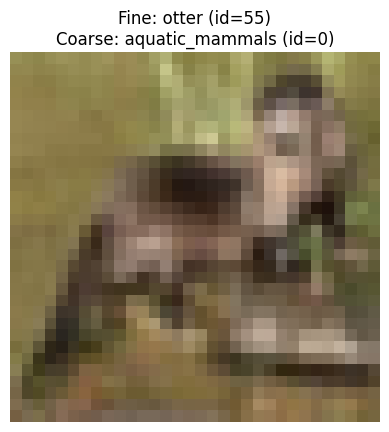

In [ ]:
import matplotlib.pyplot as plt

# Khởi tạo dataset
dataset = CIFAR100Dataset(
    root="/home/maitanha/cll_vlm/cll_vlm/data/cifar100",
    train=True
)

# Chọn index bất kỳ
idx = 100

# Lấy sample
img, fine_id = dataset[idx]

# Map fine -> coarse
coarse_id = dataset.fine_to_coarse(fine_id)

# Lấy tên label
fine_name = dataset.fine_classes[fine_id]
coarse_name = dataset.coarse_classes[coarse_id]

# Hiển thị ảnh
plt.imshow(img)
plt.axis("off")
plt.title(
    f"Fine: {fine_name} (id={fine_id})\n"
    f"Coarse: {coarse_name} (id={coarse_id})"
)
plt.show()

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model = CLIPModel(model_name="ViT-L/14@336px", device=device)

def preprocess_label(label: str) -> str:
    # special case for vehicles
    if label.startswith("vehicles_1"):
        return "transportation vehicles"
    if label.startswith("vehicles_2"):
        return "industrial and military vehicles"
    # general case
    return label.replace("_", " ")

coarse_label_names = dataset.coarse_classes
processed_labels = [preprocess_label(lbl) for lbl in coarse_label_names]
print(processed_labels)

texts = [f"A photo of a {label}" for label in processed_labels]

['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores', 'medium mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'transportation vehicles', 'industrial and military vehicles']


In [5]:
with torch.no_grad():
    text_features = clip_model.encode_text(texts)  # (20, D)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

print(text_features.shape)

torch.Size([20, 768])


In [8]:
import numpy as np


batch_size = 256
num_workers = 4

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

all_sims = []

with torch.no_grad():
    for imgs, _ in tqdm(dataloader):
        # imgs: list[PIL.Image], len = batch_size
        img_features = clip_model.encode_image(imgs)   # (B, D)
        img_features = img_features / img_features.norm(dim=-1, keepdim=True)

        sims = img_features @ text_features.T           # (B, 20)
        all_sims.append(sims.cpu().numpy())

all_sims = np.concatenate(all_sims, axis=0)
print(all_sims.shape)

100%|██████████| 196/196 [06:23<00:00,  1.96s/it]

(50000, 20)


In [9]:
save_path = "/home/maitanha/cll_vlm/cll_vlm/cifar_clip_similarity/cifar100_image_coarse.npy"
np.save(save_path, all_sims)

print(f"Saved to {save_path}")

Saved to /home/maitanha/cll_vlm/cll_vlm/cifar_clip_similarity/cifar100_image_coarse.npy


### Analyze

In [10]:
# Load similarity matrix
sim_path = "/home/maitanha/cll_vlm/cll_vlm/cifar_clip_similarity/cifar100_image_coarse.npy"
sim_matrix = np.load(sim_path)   # shape: (N, 20)

print(sim_matrix.shape)

(50000, 20)


In [ ]:
dataset = CIFAR100Dataset(
    root="/home/maitanha/cll_vlm/cll_vlm/data/cifar100",
    train=True,
    transform=None
)

# Ground-truth coarse labels
gt_fine = np.array(dataset.fine_labels)
gt_coarse = np.array([dataset.fine_to_coarse(f) for f in gt_fine])

print(gt_coarse.shape)

(50000,)


In [12]:
# Top-1 accuracy

pred_coarse = np.argmax(sim_matrix, axis=1)

top1_acc = (pred_coarse == gt_coarse).mean()
print(f"Top-1 Coarse Accuracy (CLIP): {top1_acc * 100:.2f}%")

Top-1 Coarse Accuracy (CLIP): 50.44%


In [20]:
def topk_accuracy(sim_matrix, gt, k):
    topk = np.argsort(sim_matrix, axis=1)[:, -k:]
    correct = [
        gt[i] in topk[i]
        for i in range(len(gt))
    ]
    return np.mean(correct)


for k in [2, 3, 5, 7]:
    acc = topk_accuracy(sim_matrix, gt_coarse, k)
    print(f"Top-{k} Coarse Accuracy: {acc * 100:.2f}%")

Top-2 Coarse Accuracy: 67.91%
Top-3 Coarse Accuracy: 76.67%
Top-5 Coarse Accuracy: 86.81%
Top-7 Coarse Accuracy: 92.44%


In [14]:
from collections import defaultdict

correct = (pred_coarse == gt_coarse)

per_class_acc = defaultdict(list)
for i, c in enumerate(gt_coarse):
    per_class_acc[c].append(correct[i])

print("Per-coarse accuracy:")
for c in sorted(per_class_acc.keys()):
    acc = np.mean(per_class_acc[c])
    print(f"{dataset.coarse_classes[c]:30s}: {acc * 100:.2f}%")

Per-coarse accuracy:
aquatic_mammals               : 88.56%
fish                          : 46.72%
flowers                       : 96.84%
food_containers               : 26.64%
fruit_and_vegetables          : 77.64%
household_electrical_devices  : 55.00%
household_furniture           : 81.84%
insects                       : 92.20%
large_carnivores              : 29.80%
large_man-made_outdoor_things : 10.00%
large_natural_outdoor_scenes  : 57.04%
large_omnivores_and_herbivores: 23.04%
medium_mammals                : 31.12%
non-insect_invertebrates      : 11.04%
people                        : 20.16%
reptiles                      : 11.56%
small_mammals                 : 70.76%
trees                         : 82.28%
vehicles_1                    : 54.60%
vehicles_2                    : 41.92%


In [15]:
def complementary_hit_rate(sim_matrix, gt, k):
    """
    GT coarse KHÔNG được nằm trong bottom-k
    """
    bottomk = np.argsort(sim_matrix, axis=1)[:, :k]
    correct = [
        gt[i] not in bottomk[i]
        for i in range(len(gt))
    ]
    return np.mean(correct)

for k in [1, 3, 5]:
    rate = complementary_hit_rate(sim_matrix, gt_coarse, k)
    print(f"GT NOT in bottom-{k}: {rate * 100:.2f}%")

GT NOT in bottom-1: 99.93%
GT NOT in bottom-3: 99.76%
GT NOT in bottom-5: 99.43%


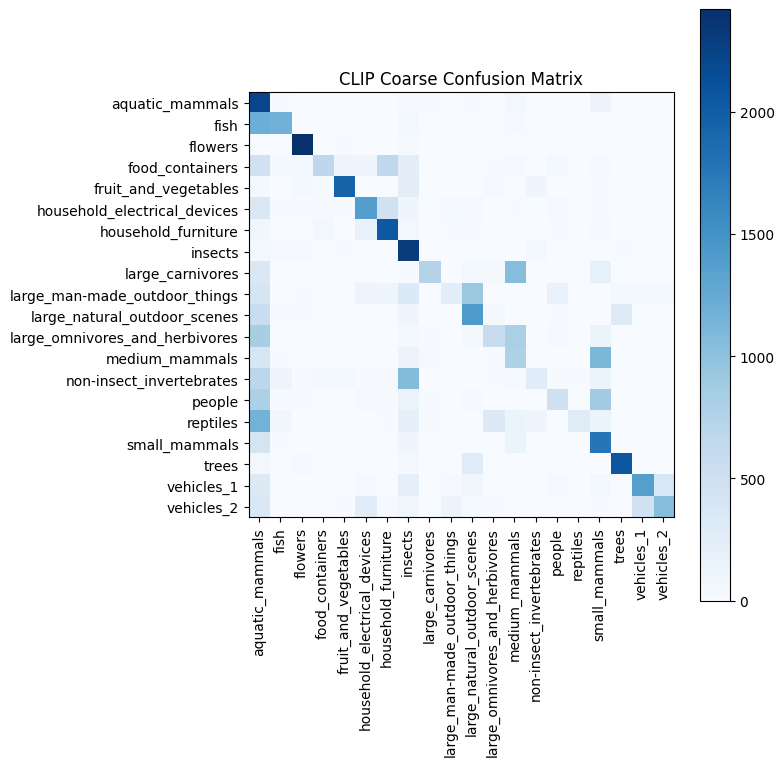

In [16]:
import sklearn.metrics as metrics

cm = metrics.confusion_matrix(gt_coarse, pred_coarse)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks(range(20), dataset.coarse_classes, rotation=90)
plt.yticks(range(20), dataset.coarse_classes)
plt.title("CLIP Coarse Confusion Matrix")
plt.tight_layout()
plt.show()


### Analyze trên data đã shuffle

In [21]:
dataset = CIFAR100Dataset(
    root="/home/maitanha/cll_vlm/cll_vlm/data/cifar100",
    train=True,
    transform=None
)

orig_dataset, shuffled_dataset = dataset.get_shuffled_labels_dataset(seed=42)

# Fine labels
orig_fine = np.array(orig_dataset.targets)
shuffled_fine = np.array(shuffled_dataset.targets)

# Map fine → coarse
orig_coarse = np.array([orig_dataset.fine_to_coarse(f) for f in orig_fine])
shuffled_coarse = np.array([orig_dataset.fine_to_coarse(f) for f in shuffled_fine])

assert len(shuffled_coarse) == sim_matrix.shape[0]

In [27]:
import numpy as np

K = 3  # top-K coarse
topk_coarse = np.argsort(sim_matrix, axis=1)[:, -K:][:, ::-1]  # (N, K)

N = sim_matrix.shape[0]

# true fine labels
true_fine = np.array([orig_dataset[i][1] for i in range(N)])

# shuffled fine labels
shuffled_fine = np.array([shuffled_dataset[i][1] for i in range(N)])

# map to coarse
true_coarse = np.array([dataset.fine_to_coarse(f) for f in true_fine])
shuffled_coarse = np.array([dataset.fine_to_coarse(f) for f in shuffled_fine])


In [28]:
# shuffled coarse NOT in top-K
is_candidate_CL = np.array([
    shuffled_coarse[i] not in topk_coarse[i]
    for i in range(N)
])

# shuffled fine != true fine
is_true_CL = shuffled_fine != true_fine

# shuffled fine != true fine
is_true_CL = shuffled_fine != true_fine

num_candidate_CL = is_candidate_CL.sum()
num_true_CL = (is_candidate_CL & is_true_CL).sum()

cl_precision = num_true_CL / num_candidate_CL if num_candidate_CL > 0 else 0.0

print(f"Total samples: {N}")
print(f"Candidate CL (shuffled coarse NOT in Top-{K}): {num_candidate_CL}")
print(f"True CL among them (shuffled != true): {num_true_CL}")
print(f"CL correctness (precision): {cl_precision * 100:.2f}%")


Total samples: 50000
Candidate CL (shuffled coarse NOT in Top-3): 42398
True CL among them (shuffled != true): 42271
CL correctness (precision): 99.70%


In [29]:
same_fine = shuffled_fine == true_fine
same_coarse = shuffled_coarse == true_coarse

fake_CL_same_fine = (is_candidate_CL & same_fine).sum()
fake_CL_same_coarse = (is_candidate_CL & same_coarse & ~same_fine).sum()

print(f"Fake CL (same fine): {fake_CL_same_fine}")
print(f"Fake CL (same coarse, diff fine): {fake_CL_same_coarse}")


Fake CL (same fine): 127
Fake CL (same coarse, diff fine): 487
